In [22]:
import nltk
from nltk.cluster.kmeans import KMeansClusterer 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import time
from sklearn.manifold import TSNE

def data_pipeline(df):
    #strip address column
    data = df.iloc[:,1:]
    log = FunctionTransformer(func=np.log1p, inverse_func=np.expm1, validate=True)
    scale = StandardScaler()
    pca =PCA(n_components=data.shape[1])
    
    #build pipeline
    pipe = Pipeline([('log', log ),
                     ('scale', scale ),
                     ('PCA', pca)])

    results = pipe.fit_transform(data)
    return pipe, results

def cluster(results, n_clusters):
    cl = KMeans(n_clusters, n_init=20, max_iter=500,n_jobs=-1, verbose=0)
    return cl.fit(results)
    

def assign_cluster_to_data(df, dflabel, cl):
    lbls = []
    addrs = list(df['accession'].values)
    for i, row in dflabel.iterrows():
        addr = row['accession']
        if row['accession'] in addrs:
            lbls.append(addrs.index(row['accession']))
        else:
            lbls.append(False)

    dflabel['cluster'] = [cl.labels_[i] for i in lbls]
    return None

def calc_tsne(results, n_components=2, perplexity=20, n_iter=300,verbose=1):
    '''
    Calculated tsne for dataset'''
    time_start = time.time()
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter,verbose=verbose,learning_rate=100)
    tsne_results = tsne.fit_transform(results)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    return tsne_results


def plot_tsne(cl, tsne_results ):
    '''
    plot'''
    
    NUM_COLORS = cl.n_clusters
    cm = plt.get_cmap('nipy_spectral')

    fig = plt.figure(figsize=(15,12)).gca(projection='3D')
    ax = fig.add_subplot(111)
    #ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


    for c in np.unique(cl.labels_):
        mask = cl.labels_==c
        if np.sum(mask) <1:
            lbl = '_nolegend_'
        else:
            lbl = c
        plt.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], s=20, alpha=.4,label=lbl)

    leg = plt.legend(bbox_to_anchor=(1, 1))
    for lh in leg.legendHandles: 
        lh.set_alpha(1)




    plt.title('T-SNE', fontsize=20)
    plt.xlabel('first principal component')
    plt.ylabel('second principal component')
    plt.show()
    
    
def find_category_of_cluster(cl,dflabel, category="Exchange"):
    #assign cluster number with the most exchanges
    type_cluster = 0
    num_of_type = 0
    lbl_density=0
    print(category)
    for clust in np.unique(cl.labels_):
        size_of_cluster = np.sum(cl.labels_==clust)
        
        
        mask = dflabel['cluster']==clust
        d = dflabel[mask]
        num = np.sum(d['category']==category)
        density = num / size_of_cluster
        if num > num_of_type:
            lbl_density=density
            num_of_type = num
            type_cluster = clust
        print('cluster number   {}   number of type found: {}    cluster size: {}   label density: {}'.format(clust,num,size_of_cluster,density))
    return type_cluster

def plot_tsne_with_labels(tsne_results,df, dflabel,categs,colors):
    #need to mask df based on which results were kept from the reclustering
    
    labeled_addresses = dflabel['address'].values
    labelmask = np.array([addr in labeled_addresses for addr in df['address'] ] )
    #helper function for category mask
    def cat(addr, labeled_addresses, dflabel):
        if addr not in labeled_addresses:
            return False
        else:
            idx = int(np.where(labeled_addresses==addr)[0][0])
            return dflabel['category'][idx]

    subset, not_subset  = tsne_results[labelmask] , tsne_results[~labelmask]
    fig = plt.figure(figsize=(15,12))
    #not labelled points
    plt.scatter(not_subset[:,0], not_subset[:,1], s=20, c='gray', alpha=.3)

    #categories
    cats = np.array([cat(addr, labeled_addresses, dflabel) for addr in df['address']])#[address_mask] ]) #added address mask for all clusters

    # # #labelled points

    # ax = fig.add_subplot(111)
    # ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    for c in list(dflabel['category'].unique()):
        mask = dflabel['category']==c
        if np.sum(mask) <1:
            lbl = '_nolegend_'
        else:
            lbl = c

        #category mask
        catmask = cats == c

        if c in categs:
            idx=categs.index(c)
            color = colors[idx]

            plt.scatter(tsne_results[(labelmask & catmask)][:,0], tsne_results[(labelmask & catmask)][:,1], s=100,c=color, alpha=1,label=lbl)

    leg = plt.legend(bbox_to_anchor=(1, 1))
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    plt.title('T-SNE', fontsize=20)
    plt.xlabel('first principal component')
    plt.ylabel('second principal component')
    plt.show()


def plot_tsne_with_labeled_clusters(tsne_results, cl, clusters, categs, colors):
    fig = plt.figure(figsize=(15,12))
    ax = fig.add_subplot(111)


    for c in np.unique(cl.labels_):
        mask = cl.labels_==c

        if c in clusters:
            idx = clusters.index(c)
            lbl = categs[idx]
            color = colors[idx]

            plt.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], s=100,c=color,alpha=.4,label=('Cluster {} - "{}" '.format(c,lbl) ))
        else:
             plt.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], c='gray',s=20, alpha=.3)

    leg = plt.legend(bbox_to_anchor=(1, 1))
    for lh in leg.legendHandles: 
        lh.set_alpha(1)




    plt.title('T-SNE', fontsize=20)
    plt.xlabel('first principal component')
    plt.ylabel('second principal component')
    plt.show()
    
def recluster(df, cl, clusters, n_clusters):
    lbls = cl.labels_
    mask = np.array([False for i in range(len(lbls))])
    for c in clusters:
        mask |= lbls==c
    subpipe, results = data_pipeline(df[mask])
    
    ##use cosine similarity! NLTK clustering implementation
    #KMeans cluster object as carrier for consistency
    subcl = cluster(results, n_clusters)
    kclusterer = KMeansClusterer(n_clusters, distance=nltk.cluster.util.cosine_distance, repeats=50)
    assigned_clusters = kclusterer.cluster(results, assign_clusters=True)
    #assign new cluster labels and cluster centroids
    subcl.labels_ = np.array(assigned_clusters)
    subcl.cluster_centers_ = np.array(kclusterer.means())
    
    return subpipe, subcl, results, df[mask]

def plot_all(tsne_results,cl,df,dflabel,clusters,categs,colors ):
    plot_tsne(cl, tsne_results)
    plot_tsne_with_labeled_clusters(tsne_results, cl, clusters, categs, colors)
    plot_tsne_with_labels(tsne_results,df, dflabel,categs,colors)

In [3]:
# %load ~/SageMaker/CreatingIPProfiles/scripts/spareme.py
#!/usr/bin/env/python3

import numpy as np
import pandas as pd

def preprocessing2(csv):
    df = pd.read_csv(csv)
    df = df.set_index('datetime')
    df = df.drop(['ip_ccount','doc_ccount', 'date', 'time', 'datetime.1'],axis=1)
    df['toDoc'] = df.groupby('ip')['accession'].shift(-1).fillna(0)
    return df

def calc_sparsity(df):
    return np.sum(df)/np.prod(df.shape)

def sparsity_matrix(col1,col2):
    df_spar = pd.crosstab(col1, col2,dropna=False)
    drop_list =[]
    for x in df_spar.index.unique():
        if x not in df_spar.columns.unique():
            drop_list.append(x)
    return df_spar.drop(drop_list).drop(0, axis=1)

def create_sparsity_matrix(csv):
    df = preprocessing2(csv)
    return sparsity_matrix(df.accession, df.toDoc)


In [4]:
results = create_sparsity_matrix('~/SageMaker/CreatingIPProfiles/data/df_filtered.csv')

In [7]:
csv = '~/SageMaker/CreatingIPProfiles/data/df_filtered.csv'

In [8]:
cl = cluster(results, n_clusters=8)

In [9]:
df = preprocessing2(csv)

In [11]:
import networkx as nx

In [46]:
g_matrix = np.array(results)
G = nx.Graph(g_matrix)
d= nx.degree_centrality(G)
X = np.array([[key,val] for (key,val) in d.items()])

In [47]:
tsne_results = calc_tsne(X, perplexity=50,n_iter=2000)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4333 samples in 0.020s...
[t-SNE] Computed neighbors for 4333 samples in 0.048s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4333
[t-SNE] Computed conditional probabilities for sample 2000 / 4333
[t-SNE] Computed conditional probabilities for sample 3000 / 4333
[t-SNE] Computed conditional probabilities for sample 4000 / 4333
[t-SNE] Computed conditional probabilities for sample 4333 / 4333
[t-SNE] Mean sigma: 17.447748
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.536728
[t-SNE] KL divergence after 2000 iterations: 0.262535
t-SNE done! Time elapsed: 28.452682495117188 seconds


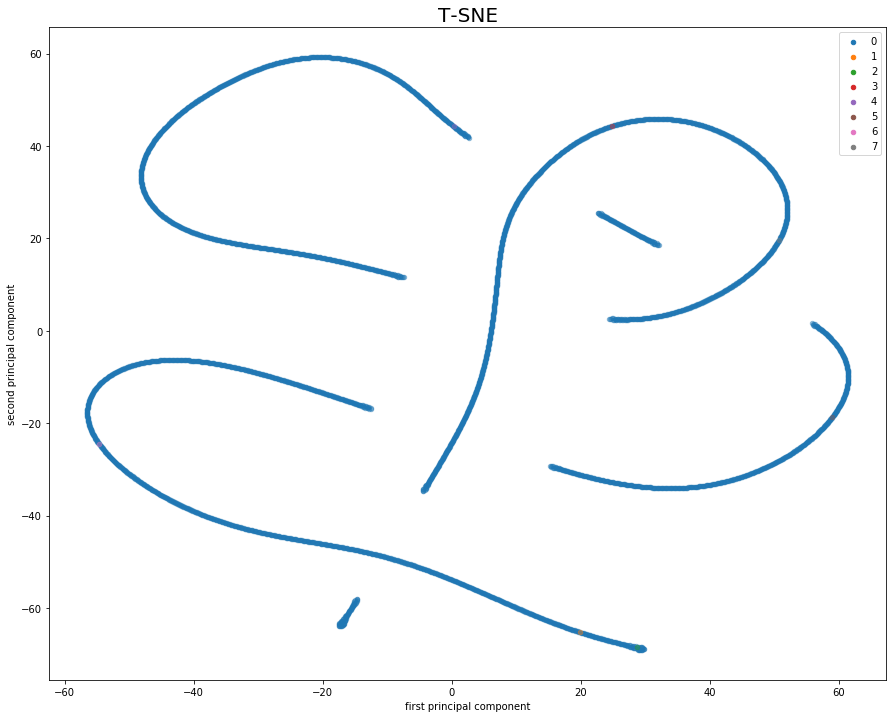

In [48]:
plot_tsne(cl, tsne_results)

In [49]:
X = np.array([[key,val] for (key,val) in d.items()])

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(tsne_results)
y_kmeans = kmeans.predict(tsne_results)



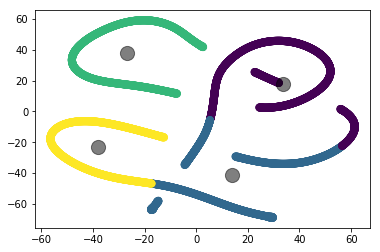

In [50]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

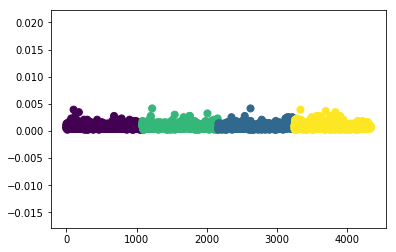

In [28]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

For n_clusters = 12 The average silhouette_score is : 0.9117222903774234


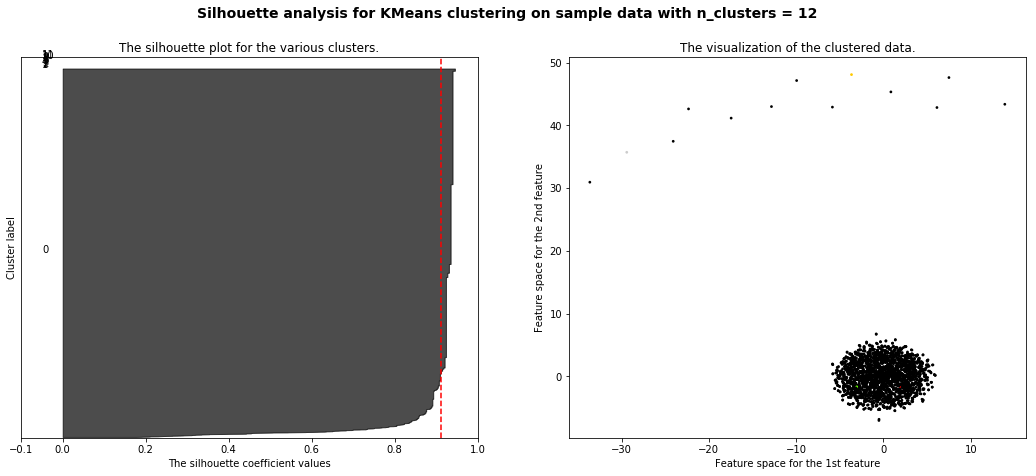

In [44]:
range_n_clusters = [12]
sils = silhouette_plotter(results, range_n_clusters, tsne_results)

In [39]:


# from sklearn.cluster import AgglomerativeClustering
# from scipy.cluster.hierarchy import dendrogram, linkage

# ag = AgglomerativeClustering(n_clusters=8)



# c = cl.cluster_centers_
# df_scaled = pd.DataFrame(c, columns = df.columns, index=np.unique(cl.labels_))


# Z = linkage(results, method='average',metric='euclidean')
# fig=plt.figure(figsize=(25,12))
# dendrogram(Z,color_threshold=8) 
# # plt.ylim(0,1e8)
# # plt.yscale('log')
# # plt.ylim(1.5,60)
# # plt.title("Cluster Dendrogram", fontsize=30)
# plt.ylabel('Log Distance', fontsize=15)
# plt.yticks([])
# plt.xlabel("Cluster Number", fontsize=15)
# plt.xticks(fontsize=20, rotation='horizontal')
# plt.show()


In [38]:
def recluster(df, cl, clusters, n_clusters):
    lbls = cl.labels_
    mask = np.array([False for i in range(len(lbls))])
    for c in clusters:
        mask |= lbls==c
    subpipe, results = data_pipeline(df[mask])
    
    ##use cosine similarity! NLTK clustering implementation
    #KMeans cluster object as carrier for consistency
    subcl = cluster(results, n_clusters)
    kclusterer = KMeansClusterer(n_clusters, distance=nltk.cluster.util.cosine_distance, repeats=50)
    assigned_clusters = kclusterer.cluster(results, assign_clusters=True)
    #assign new cluster labels and cluster centroids
    subcl.labels_ = np.array(assigned_clusters)
    subcl.cluster_centers_ = np.array(kclusterer.means())
    
    return subpipe, subcl, results, df[mask]

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm

def sil_scores(X, range_n_clusters ):
    result = []
    for n_clusters in range_n_clusters:
    #     X=data
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, n_init=20, max_iter=500)
        cluster_labels = clusterer.fit_predict(X)



        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)
        result.append(silhouette_avg)
    return result

def silhouette_plotter(X, range_n_clusters, tsne_X ):
    all_scores = []
    for n_clusters in range_n_clusters:
    #     X=data
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)



        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        all_scores.append(silhouette_avg)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)


        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / 8)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / 8)
        ax2.scatter(tsne_X[:, 0], tsne_X[:, 1], marker='.', s=30, lw=0, alpha=1,
                    c=colors, edgecolor='k')

            

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        #ax2.set_yscale('log')
        #ax2.set_xscale('log')
        #ax2.set_xlim(.0001,1000)
        #ax2.set_ylim(.0001,1000)
        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()
    return all_scores

In [52]:
d_centrality = d

In [53]:
d_between = nx.betweenness_centrality(G)

In [61]:
d_eigen = nx.eigenvector_centrality(G, max_iter=1000)

In [63]:
eigen_frame = pd.DataFrame.from_dict(d_eigen, orient='index')
between_frame = pd.DataFrame.from_dict(d_between, orient='index')
central_frame = pd.DataFrame.from_dict(d_between, orient='index')

In [76]:
frames = [eigen_frame, between_frame, central_frame]
df_conc = pd.concat(frames, axis=1)
df_conc.columns = ['Eigenvector_Centrality', 'Betweenness_Centrality', 'Centrality']

In [77]:
df_conc.shape

(4333, 3)

In [78]:
df_conc.head()

,Eigenvector_Centrality,Betweenness_Centrality,Centrality
0,2.906835e-34,0.000000e+00,0.000000e+00
1,3.821598e-02,2.064344e-03,2.064344e-03
2,8.551893e-09,3.997998e-04,3.997998e-04
3,2.835723e-04,5.581527e-03,5.581527e-03
4,1.957307e-03,1.065991e-07,1.065991e-07


In [79]:
clusters = 7
  
kmeans = KMeans(n_clusters = clusters) 
kmeans.fit(df_conc) 
  
print(kmeans.labels_)

[0 0 0 ... 0 0 0]


In [80]:
kmeans.inertia_

0.17083059101664583

In [82]:
pca = PCA(3) 
pca.fit(df_conc) 
  
pca_data = pd.DataFrame(pca.transform(df_conc)) 

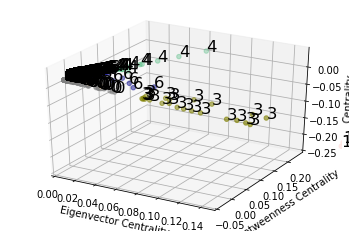

In [117]:

from matplotlib import colors as mcolors 
import math 
   
''' Generating different colors in ascending order  
                                of their hsv values '''
colors = list(zip(*sorted(( 
                    tuple(mcolors.rgb_to_hsv( 
                          mcolors.to_rgba(color)[:3])), name) 
                     for name, color in dict( 
                            mcolors.BASE_COLORS, **mcolors.CSS4_COLORS 
                                                      ).items())))[1] 
   
   
# number of steps to taken generate n(clusters) colors  
skips = math.floor(len(colors[5 : -5])/clusters) 
cluster_colors = colors[5 : -5 : skips] 


from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt 
   
fig = plt.figure() 
ax = fig.add_subplot(111, projection = '3d') 
ax.scatter(pca_data[0], pca_data[1], pca_data[2],  
           c = list(map(lambda label : cluster_colors[label], 
                                            kmeans.labels_))) 
ax.set_xlim(0, .15)
ax.set_ylim(-.05, .25)
ax.set_zlim(-.25, .05)
ax.set_xlabel('Eigenvector Centrality')
ax.set_ylabel('Betweenness Centrality')
ax.set_zlabel('Centrality')
str_labels = list(map(lambda label:'% s' % label, kmeans.labels_)) 
   
list(map(lambda data1, data2, data3, str_label: 
         ax.text(data1, data2, data3, s = str_label, size = 16.5, 
         zorder = 20, color = 'k'), pca_data[0], pca_data[1], 
         pca_data[2], str_labels)) 

plt.show() 


In [108]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import homogeneity_score, completeness_score,v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score


db = DBSCAN(eps=0.3, min_samples=10).fit(results)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
labels_true = results.columns

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % completeness_score(labels_true, labels))
print("V-measure: %0.3f" % v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X, labels))

Estimated number of clusters: 1
Estimated number of noise points: 4306
Homogeneity: 0.005
Completeness: 1.000
V-measure: 0.009
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Silhouette Coefficient: 0.009


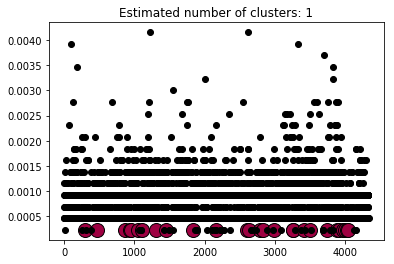

In [115]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()